<span>
<b>Authors:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a>, <a href="https://andreafailla.github.io/">Andrea Failla</a><br/>
<b>Python version:</b>  >=3.7<br/>
<b>Networkx version:</b>  >=2.3<br/>
<b>Last update:</b> 03/07/2025
</span>

<a id='top'></a>
# Ties Strength & Resilience*

In this notebook are introduced some of the main analysis discussed in lecture 7.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started.

In [31]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Reading Game of Thrones Season 6 edge data and defining the graph g (useful for further operations)

In [ ]:
!git clone https://github.com/sna-unipi/SNA-lectures-notebooks.git
!mkdir asioaf
!cp -r SNA-lectures-notebooks/data/asioaf/* asioaf/
!rm -rf SNA-lectures-notebooks

In [32]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1], weight=int(l[2]))
    return g

# Game of Thrones data
season = 6
g = read_net_w(f'asioaf/got-s{season}-edges.csv')

## Bridges and Local Bridges

Checking if graph has bridges

In [33]:
nx.has_bridges(g)

True

Generating all bridges in the graph

In [34]:
list(nx.bridges(g))

[('JON', 'SAM'),
 ('JON', 'JEOR'),
 ('MISSANDEI', 'KRAZNYS_MO_NAKLOZ'),
 ('TYRION', 'AERYS'),
 ('DAVOS', 'SHIREEN'),
 ('SAM', 'MAESTER_AEMON'),
 ('CERSEI', 'MOUNTAIN'),
 ('TORMUND', 'MANCE'),
 ('HOUND', 'GATINS'),
 ('BRYNDEN', 'MINISA'),
 ('EDMURE', 'HOSTER'),
 ('QYBURN', 'ARTHUR_CHILD'),
 ('NED', 'RICKARD_STARK')]

Generating all local bridges in the graph and computing the span (i.e., the shortest path length between the endpoints if the local bridge is removed)

In [35]:
list(nx.local_bridges(g, with_span=True))

[('JON', 'SAM', inf),
 ('JON', 'JEOR', inf),
 ('MISSANDEI', 'KRAZNYS_MO_NAKLOZ', inf),
 ('TYRION', 'AERYS', inf),
 ('VARYS', 'STANNIS', 3),
 ('ARYA', 'WALDER', 3),
 ('DAVOS', 'SHIREEN', inf),
 ('SAM', 'MAESTER_AEMON', inf),
 ('CERSEI', 'MOUNTAIN', inf),
 ('TORMUND', 'MANCE', inf),
 ('HOUND', 'GATINS', inf),
 ('BRYNDEN', 'MINISA', inf),
 ('EDMURE', 'HOSTER', inf),
 ('QYBURN', 'ARTHUR_CHILD', inf),
 ('NED', 'RICKARD_STARK', inf)]

In [36]:
# add to edges
for u, v, span in nx.local_bridges(g, with_span=True):
    g[u][v]['span'] = span

## Tie Strength

Measuring Tie Strength for each pair of nodes in the graph through Neighborhood Overlap

In [37]:
def neighborhood_overlap(G, u, v):
    """
    Compute overlap O_uv = |N(u) ∩ N(v)| / |N(u) ∪ N(v)|
    (excluding u,v themselves).
    """
    nbrs_u = set(G[u]) - {v}
    nbrs_v = set(G[v]) - {u}
    inter = nbrs_u & nbrs_v
    union = nbrs_u | nbrs_v
    return len(inter) / len(union) if union else 0.0


In [38]:
for u, v in g.edges():
    g[u][v]['overlap'] = neighborhood_overlap(g, u, v)

Plotting the KDE (Kernel Density Estimation) of Neighborhood Overlap

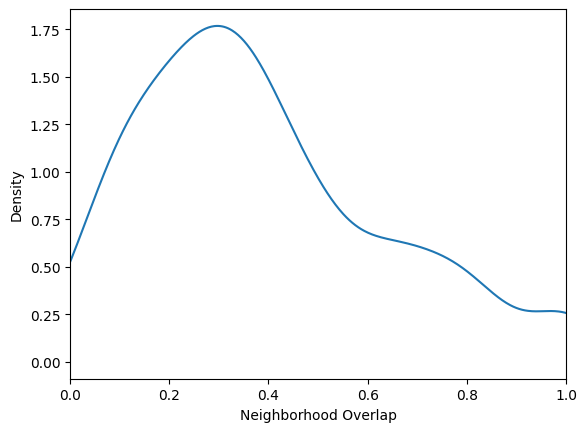

In [41]:
weights = [e[-1]['overlap'] for e in g.edges(data=True)]
pd.DataFrame(weights)[0].plot.kde()
plt.xlabel("Neighborhood Overlap")
plt.ylabel("Density")
plt.xlim(0,1)
plt.show()

Plotting the KDE (Kernel Density Estimation) of Interactions Weights

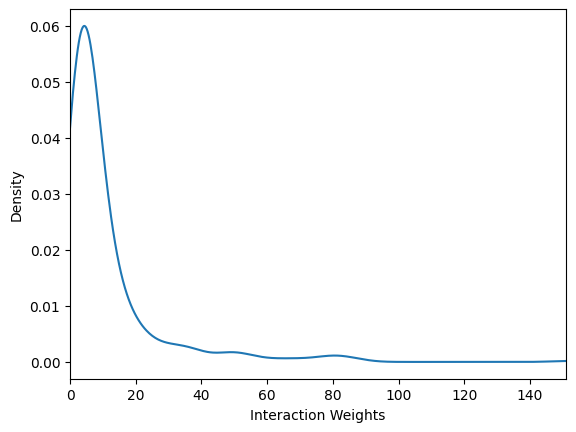

In [42]:
weights_got = [d['weight'] for u,v,d in g.edges(data=True)]
pd.DataFrame(weights_got)[0].plot.kde()
plt.xlabel("Interaction Weights")
plt.ylabel("Density")
plt.xlim(0,max(weights_got))
plt.show()

## Network Resilience
In the following we:
- generate Random and Scale-free Network
- compute Reslience for both Networks (through molloy_reed and breakdown_threshold)
- plot Game of Thrones graph Resilience under Random Failure and Targeted Attacks

Generating Networks

In [43]:
# Random
er = nx.erdos_renyi_graph(1000, 0.001)
# Scale-free
ba = nx.barabasi_albert_graph(1000, 2)

Computing node degree for both ER and BA Networks

In [44]:
er_degs = list(dict(er.degree()).values())
ba_degs = list(dict(ba.degree()).values())

Defining Molloy-Reed threshold

In [45]:
def molloy_reed(degrees):
    return (np.mean(degrees)*(np.mean(degrees)+1))/np.mean(degrees)

def breakdown_threshold(degrees):
    K = molloy_reed(degrees)
    return 1 - (1/(K-1))

Random network

In [46]:
molloy_reed(er_degs)

1.95

In [47]:
breakdown_threshold(er_degs)

-0.05263157894736836

Scale-free network

In [48]:
molloy_reed(ba_degs)

4.992

In [49]:
breakdown_threshold(ba_degs)

0.7494989979959921

### Random Failures

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def random_node(g): # select a random node from graph
    return [np.random.choice(g.nodes())]

def dismantle(g, function, **args): # incrementally removes node from a graph and computes size of connected components
    total_nodes = g.number_of_nodes()
    removed_nodes = []
    components = []
    while len(g.nodes()) > 1:
        n = function(g, **args)[0]
        g.remove_node(n)
        removed_nodes.append((len(removed_nodes)+1)/total_nodes)
        comps = list(nx.connected_components(g))
        g_size = 0
        if len(comps)>0:
            g_size  = max([len(c)for c in comps])/total_nodes
        components.append(g_size)
    return removed_nodes, components

def get_sorted_nodes(g, score, reverse=True): # sort nodes
    nodes = score(g)
    if isinstance(nodes, dict):
        nodes = [(k, v) for k, v in nodes.items()]
    srt = sorted(nodes, key = lambda k: k[1], reverse = reverse)
    return [x[0] for x in srt]

def plot_dismantle(x, y, ax=None, **kwargs):
    """
    Plot dismantling results on a given axis or create new plot.

    Parameters:
    -----------
    x : list or array
        X-axis data (removed nodes)
    y : list or array
        Y-axis data (giant component size)
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, creates new figure
    **kwargs : dict
        Additional keyword arguments passed to plot function
    """
    if ax is None:
        fig, ax = plt.subplots()
        show_plot = True
    else:
        show_plot = False

    ax.plot(x, y, **kwargs)
    ax.set_xlabel("Removed Nodes")
    ax.set_ylabel("Giant Component size")

    if show_plot:
        plt.show()


Random Failure:
- Giant component size has a consistent decrease when a big fraction of nodes is removed

In [50]:
print(g)

Graph with 142 nodes and 541 edges


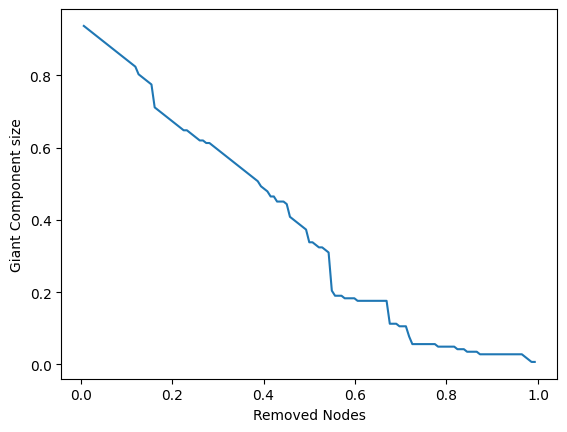

In [51]:
h = g.copy()
rn, comps = dismantle(h, random_node)
plot_dismantle(rn, comps)

### Targeted Attacks

Targeted Node attack (hubs are removed first)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

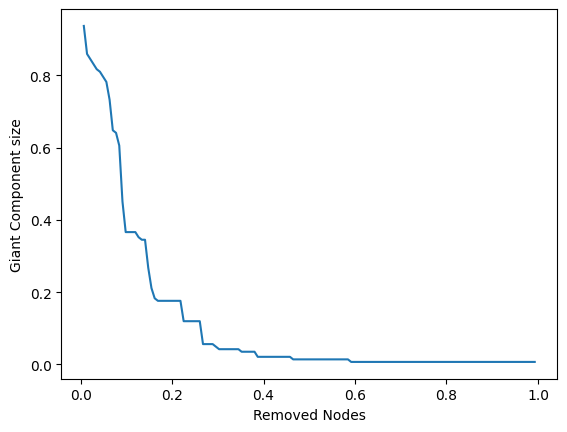

In [52]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.degree)
plot_dismantle(rn, comps)

Targeted Edge Attack (based on Edge Betweenness Centrality)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

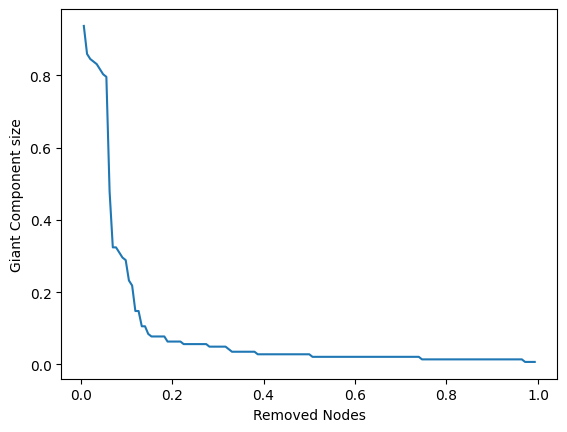

In [53]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.betweenness_centrality)
plot_dismantle(rn, comps)

Targeted Edge Attack (based on Edge Harmonic Centrality)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

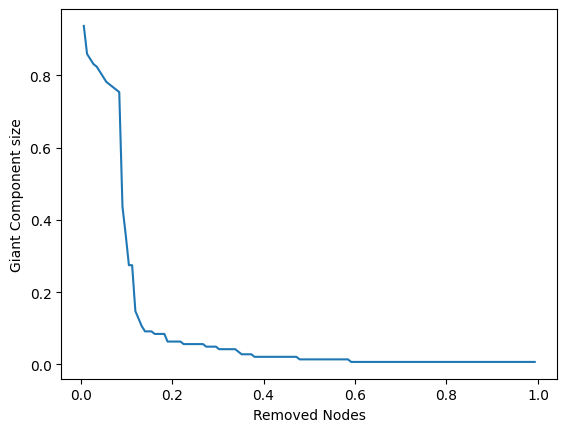

In [54]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.harmonic_centrality)
plot_dismantle(rn, comps)

## Exercises

### Tie strength over time
Load the Game of Thrones networks for different seasons (seasons 1-6)
- For each season, compute the neighborhood overlap for all edges
- Create visualizations comparing the distribution of tie strengths across seasons

## Failures and attacks on different topologies
* Generate three types of networks with the same number of nodes (500):
   - Erdős-Rényi random graph
   - Barabási-Albert scale-free graph
   - Watts-Strogatz small-world graph


* For each network:
   - Calculate the Molloy-Reed threshold
   - Compute the breakdown threshold
   - Simulate random failures (random node removal) and targeted attacks (high-degree first)
   - Plot the giant component size vs. fraction of removed nodes